In [4]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
import numpy as np
import scipy.linalg as la

In [5]:
backend = Aer.get_backend('qasm_simulator')
def get_noise(p_meas, p_gate):
    error_meas = pauli_error([('X', p_meas), ('I', 1- p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)
    
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x", "id"])
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])
    
    return noise_model

{'0': 1013, '1': 11}


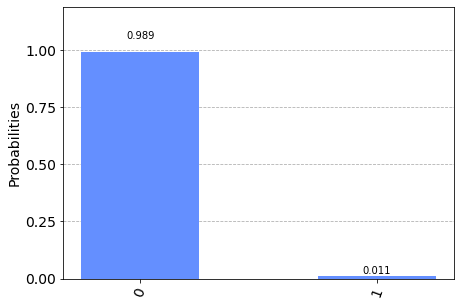

In [6]:
noise_model = get_noise(0.01, 0.05)
N = 10
qc3 = QuantumCircuit(1, 1)
for i in range(N):
    qc3.x(0)
    qc3.x(0)

qc3.measure(qc3.qregs[0], qc3.cregs[0])
counts = execute(qc3, backend, noise_model=noise_model).result().get_counts()

print(counts)
plot_histogram(counts)
#qc3.draw('mpl')

{'11': 176, '01': 634, '00': 123, '10': 91}


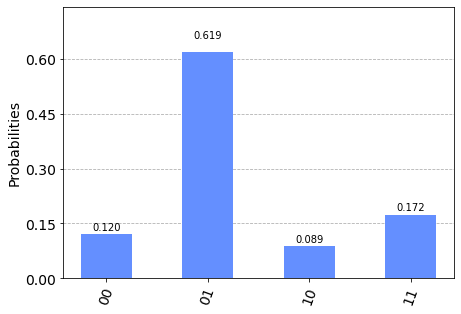

In [7]:
noise_model = get_noise(0.01, 0.05)
N = 5
qc4 = QuantumCircuit(2,2)
qc4.x(0)
for i in range(N):
    qc4.cx(0, 1)
    qc4.barrier()
    qc4.cx(0,1)
    qc4.barrier()

qc4.measure(qc4.qregs[0], qc4.cregs[0])
counts = execute(qc4, backend, noise_model=noise_model).result().get_counts()
print(counts)
plot_histogram(counts)
#c4.draw('mpl')

{'10111': 12, '01111': 14, '00111': 1, '11111': 951, '01101': 1, '11110': 21, '11011': 13, '11101': 10, '10101': 1}


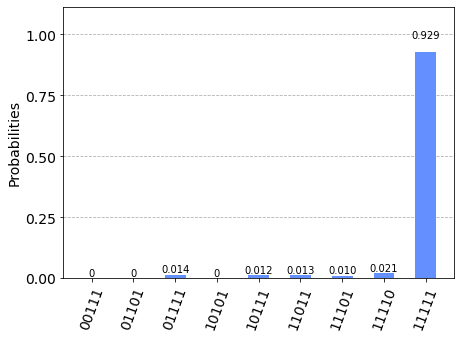

In [25]:
noise_model = get_noise(0.01, 0.01)
qc0 = QuantumCircuit(5, 5, name='0')
for i in range(5):
    qc0.x(i)
qc0.measure(qc0.qregs[0], qc0.cregs[0])
qc0.draw('mpl')
counts = execute(qc0, backend, noise_model=noise_model).result().get_counts()
print(counts)
plot_histogram(counts)


{'111': 982, '110': 15, '101': 11, '011': 16}


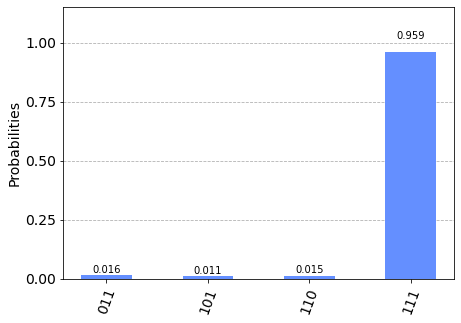

In [24]:
qc1 = QuantumCircuit(3, 3, name='0')
qc1.x(qc1.qregs[0])
qc1.measure(qc1.qregs[0], qc1.cregs[0])

counts = execute(qc1, backend, noise_model=noise_model).result().get_counts()

print(counts)
plot_histogram(counts)

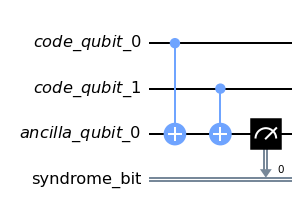

In [9]:
cq = QuantumRegister(2, 'code_qubit')
lq = QuantumRegister(1, 'ancilla_qubit')
sb = ClassicalRegister(1, 'syndrome_bit')
qc = QuantumCircuit(cq, lq, sb)
qc.cx(cq[0], lq[0])
qc.cx(cq[1], lq[0])
qc.measure(lq, sb)
qc.draw("mpl")

In [10]:
qc_init = QuantumCircuit(3,1)
counts = execute(qc_init.compose(qc), backend).result().get_counts()
print(counts)

{'0': 1024}


In [11]:
qc_init = QuantumCircuit(3, 1)
qc_init.x(0)
qc_init.x(1)
counts = execute(qc_init.compose(qc), backend).result().get_counts()
print("Results: ", counts)

Results:  {'0': 1024}


In [12]:
qc_init = QuantumCircuit(3,1)
qc_init.h(0)
qc_init.cx(0,1)
counts = execute(qc_init.compose(qc), backend).result().get_counts()
print("Results: ", counts)

Results:  {'0': 1024}


In [13]:
qc_init = QuantumCircuit(3, 1)
qc_init.x(0)
counts = execute(qc_init.compose(qc), backend).result().get_counts()
print("Result: ", counts)

Result:  {'1': 1024}


In [14]:
def get_noise(p):
    error_meas = pauli_error([('X', p), ('I', 1-p)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    return noise_model

In [16]:
noise_model = get_noise(0.01)
for state in ['00', '01', '10', '11']:
    qc = QuantumCircuit(2,2)
    if state[0] == '1':
        qc.x(1)
    if state[1] == '1':
        qc.x(0)
    qc.measure(qc.qregs[0], qc.cregs[0])
    print(state+' becomes', execute(qc, Aer.get_backend('qasm_simulator'), noise_model=noise_model, shots=10000).result().get_counts())

00 becomes {'00': 9778, '10': 122, '01': 100}
01 becomes {'01': 9822, '11': 84, '00': 94}
10 becomes {'10': 9791, '00': 105, '11': 103, '01': 1}
11 becomes {'11': 9806, '10': 108, '01': 86}


In [18]:
qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure(qc.qregs[0], qc.cregs[0])
print(execute(qc, Aer.get_backend('qasm_simulator'), noise_model=noise_model, shots=10000).result().get_counts())

{'00': 4960, '01': 103, '11': 4849, '10': 88}


In [26]:
M = [[0.9777, 0.0112, 0.0100, 0.0002],
     [0.0112, 0.9778, 0.0001, 0.0109],
     [0.0100, 0.0, 0.9788, 0.0112],
     [0.0002, 0.0084, 0.0113, 0.9801]]

Cideal = [[5000],
          [0],
          [0],
          [5000]]
Cnoisy = np.dot(M, Cideal)
print("C_noisy=\n", Cnoisy)

C_noisy=
 [[4889.5]
 [ 110.5]
 [ 106. ]
 [4901.5]]


In [27]:
Minv = la.inv(M)
print(Minv)

[[ 1.02304976e+00 -1.17186559e-02 -1.04513578e-02  4.09943919e-05]
 [-1.17173704e-02  1.02293597e+00  1.46531715e-04 -1.13756757e-02]
 [-1.04522210e-02  2.20044977e-04  1.02190076e+00 -1.16779885e-02]
 [ 1.21682031e-05 -8.76727366e-03 -1.17810623e-02  1.02053618e+00]]


In [28]:
Cmeasured = [4900, 104, 98, 4898]
Cmitigated = np.dot(Minv, Cmeasured)
print("C_mitigated=\n", Cmitigated)

C_mitigated=
 [5010.90166117   -6.73347357   -8.24551171 4996.57948692]


In [31]:
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
for circuit in meas_calibs:
    print('Circuit', circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
         ░ ┌─┐   
q116_0: ─░─┤M├───
         ░ └╥┘┌─┐
q116_1: ─░──╫─┤M├
         ░  ║ └╥┘
  c0: 2/════╩══╩═
            0  1 

Circuit mcalcal_01
        ┌───┐ ░ ┌─┐   
q116_0: ┤ X ├─░─┤M├───
        └───┘ ░ └╥┘┌─┐
q116_1: ──────░──╫─┤M├
              ░  ║ └╥┘
  c0: 2/═════════╩══╩═
                 0  1 

Circuit mcalcal_10
              ░ ┌─┐   
q116_0: ──────░─┤M├───
        ┌───┐ ░ └╥┘┌─┐
q116_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
  c0: 2/═════════╩══╩═
                 0  1 

Circuit mcalcal_11
        ┌───┐ ░ ┌─┐   
q116_0: ┤ X ├─░─┤M├───
        ├───┤ ░ └╥┘┌─┐
q116_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
  c0: 2/═════════╩══╩═
                 0  1 



In [33]:
noise_model = get_noise(0.1)
backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.821 0.068 0.1   0.01 ]
 [0.085 0.827 0.01  0.096]
 [0.085 0.015 0.806 0.082]
 [0.009 0.09  0.084 0.812]]


In [34]:


qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure(qc.qregs[0], qc.cregs[0])

results = execute(qc, backend=backend, shots=10000, noise_model=noise_model).result()

noisy_counts = results.get_counts()
print(noisy_counts)

{'00': 4117, '11': 4055, '10': 942, '01': 886}


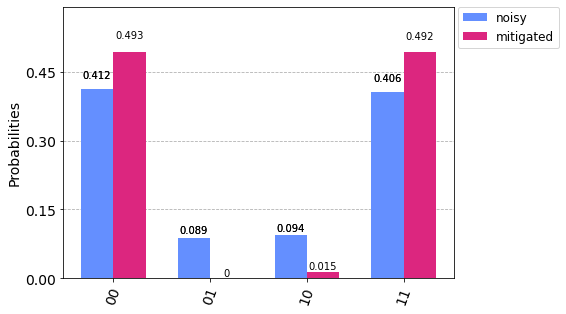

In [36]:
meas_filter = meas_fitter.filter

mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)


plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

{'010': 411, '110': 454, '100': 3643, '011': 3710, '000': 426, '101': 421, '111': 478, '001': 457}


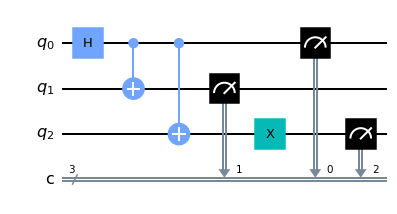

In [49]:
qr = QuantumRegister(3)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')


noise_model = get_noise(0.1)
backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

qc = QuantumCircuit(3, 3)
qc.h(0)
qc.cx(0, 1)
qc.cx(0, 2)
qc.x(2)
qc.measure(qc.qregs[0], qc.cregs[0])

results = execute(qc, backend=backend, shots=10000, noise_model=noise_model).result()

noisy_counts = results.get_counts()

print(noisy_counts)
qc.draw('mpl')

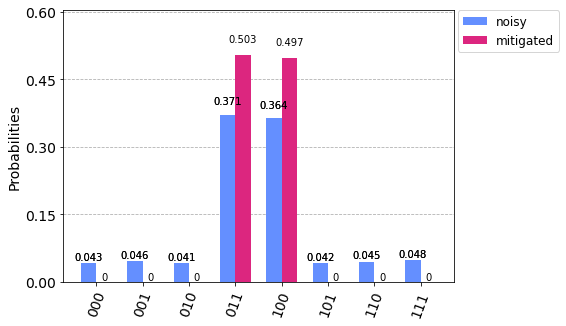

In [50]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_filter = meas_fitter.filter

mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])